In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=Warning)
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/503/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/503/test.csv')
historical_transactions = pd.read_csv('/content/drive/MyDrive/503/history_trans.csv')
new_merchant_transactions = pd.read_csv('/content/drive/MyDrive/503/new_transaction_merchant_data.csv')

In [ ]:
train_data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [ ]:
# feature selection extract year and month
train_data['first_active_month'] = pd.to_datetime(train_data['first_active_month'])
test_data['first_active_month'] = pd.to_datetime(test_data['first_active_month'])
train_data['month'] = train_data['first_active_month'].dt.month
test_data['month'] = test_data['first_active_month'].dt.month
train_data['year'] = train_data['first_active_month'].dt.year
test_data['year'] = test_data['first_active_month'].dt.year

In [ ]:
# 第一次激活时间到最后一个月之间的间隔月
last_date = pd.to_datetime('2018-02-01')
train_data['time_diff'] = (last_date.year - train_data['first_active_month'].dt.year) * 12 + (last_date.month - train_data['first_active_month'].dt.month)
test_data['time_diff'] = (last_date.year - test_data['first_active_month'].dt.year) * 12 + (last_date.month - test_data['first_active_month'].dt.month)

In [ ]:
# Using label encoding for year
le = LabelEncoder()
train_data['year'] = le.fit_transform(train_data['year'])
test_data['year'] = le.fit_transform(test_data['year'])

In [ ]:
# 首次活跃月份进行编码
le = LabelEncoder()
train_data['first_active_month'] = le.fit_transform(train_data['first_active_month'])
test_data['first_active_month'] = le.fit_transform(test_data['first_active_month'])

In [ ]:
# using Standardiza for numerical columns
scaler = StandardScaler()
# 对 train_data['time_diff'] 进行缩放
train_data['time_diff'] = scaler.fit_transform(train_data['time_diff'].values.reshape(-1, 1))

# 对 test_data['time_diff'] 进行缩放
test_data['time_diff'] = scaler.transform(test_data['time_diff'].values.reshape(-1, 1))

In [ ]:
# merge historical and new data with train and test data
train_merge_data_hist = pd.merge(train_data, historical_transactions, on='card_id', how='left')
test_merge_data_hist = pd.merge(test_data, historical_transactions, on='card_id', how='left')
train_merge_data = pd.merge(train_merge_data_hist, new_merchant_transactions, on='card_id', how='left')
test_merge_data = pd.merge(test_merge_data_hist, new_merchant_transactions, on='card_id', how='left')

In [ ]:
train_merge_data.drop(['hist_purchase_amount_sum','card_id'], axis=1, inplace=True)
cardid_test = test_merge_data['card_id']
test_merge_data.drop(['hist_purchase_amount_sum','card_id'], axis=1, inplace=True)

In [ ]:
print(train_merge_data.shape)
print(test_merge_data.shape)

(201917, 181)
(123623, 180)


In [ ]:
#fill the missing value with mean
train_merge_data.fillna(train_merge_data.mean(), inplace=True)
test_merge_data.fillna(test_merge_data.mean(), inplace=True)


In [ ]:
#save
train_merge_data.to_csv('/content/drive/MyDrive/503/train_merge_data.csv', index=False)
test_merge_data.to_csv('/content/drive/MyDrive/503/test_merge_data.csv', index=False)

In [ ]:
# read csv files
train_merge_data = pd.read_csv('/content/drive/MyDrive/503/train_merge_data.csv')
test_merge_data = pd.read_csv('/content/drive/MyDrive/503/test_merge_data.csv')

# EDA

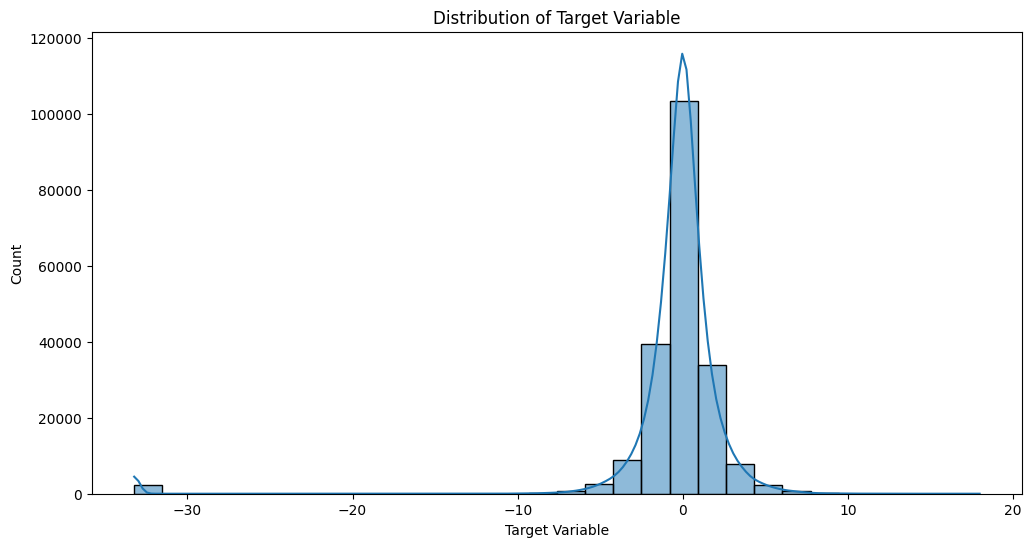

In [ ]:
# target distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_merge_data['target'], bins=30, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()
# 有一小段在-30，最多的在0附近，正态分布

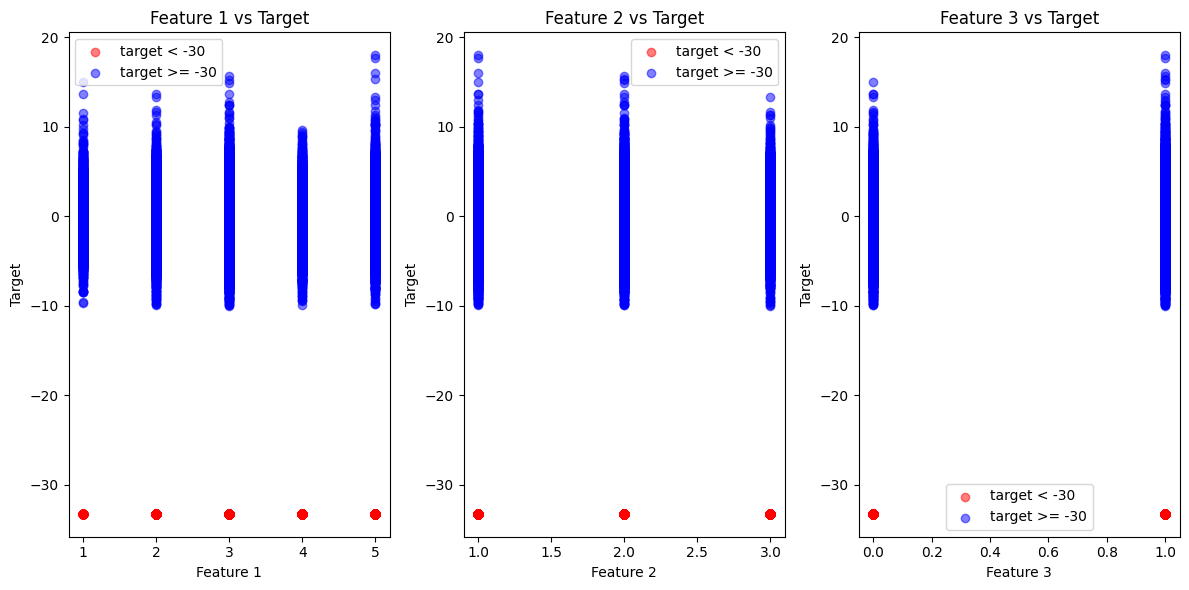

In [ ]:
y_outlier = train_merge_data[train_merge_data['target']<-30]
y_normal = train_merge_data[train_merge_data['target']>=-10]
# see the relationship between features and normal target and outlier target
plt.figure(figsize=(12, 6))
# feature_1 与 target 的关系
plt.subplot(1, 3, 1)
plt.scatter(y_outlier['feature_1'], y_outlier['target'], color='red', label='target < -30', alpha=0.5)
plt.scatter(y_normal['feature_1'], y_normal['target'], color='blue', label='target >= -30', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Feature 1 vs Target')
plt.legend()

# feature_2 与 target 的关系
plt.subplot(1, 3, 2)
plt.scatter(y_outlier['feature_2'], y_outlier['target'], color='red', label='target < -30', alpha=0.5)
plt.scatter(y_normal['feature_2'], y_normal['target'], color='blue', label='target >= -30', alpha=0.5)
plt.xlabel('Feature 2')
plt.ylabel('Target')
plt.title('Feature 2 vs Target')
plt.legend()

# the relationship between feature_3 and target
plt.subplot(1, 3, 3)
plt.scatter(y_outlier['feature_3'], y_outlier['target'], color='red', label='target < -30', alpha=0.5)
plt.scatter(y_normal['feature_3'], y_normal['target'], color='blue', label='target >= -30', alpha=0.5)
plt.xlabel('Feature 3')
plt.ylabel('Target')
plt.title('Feature 3 vs Target')
plt.legend()

plt.tight_layout()
plt.show()


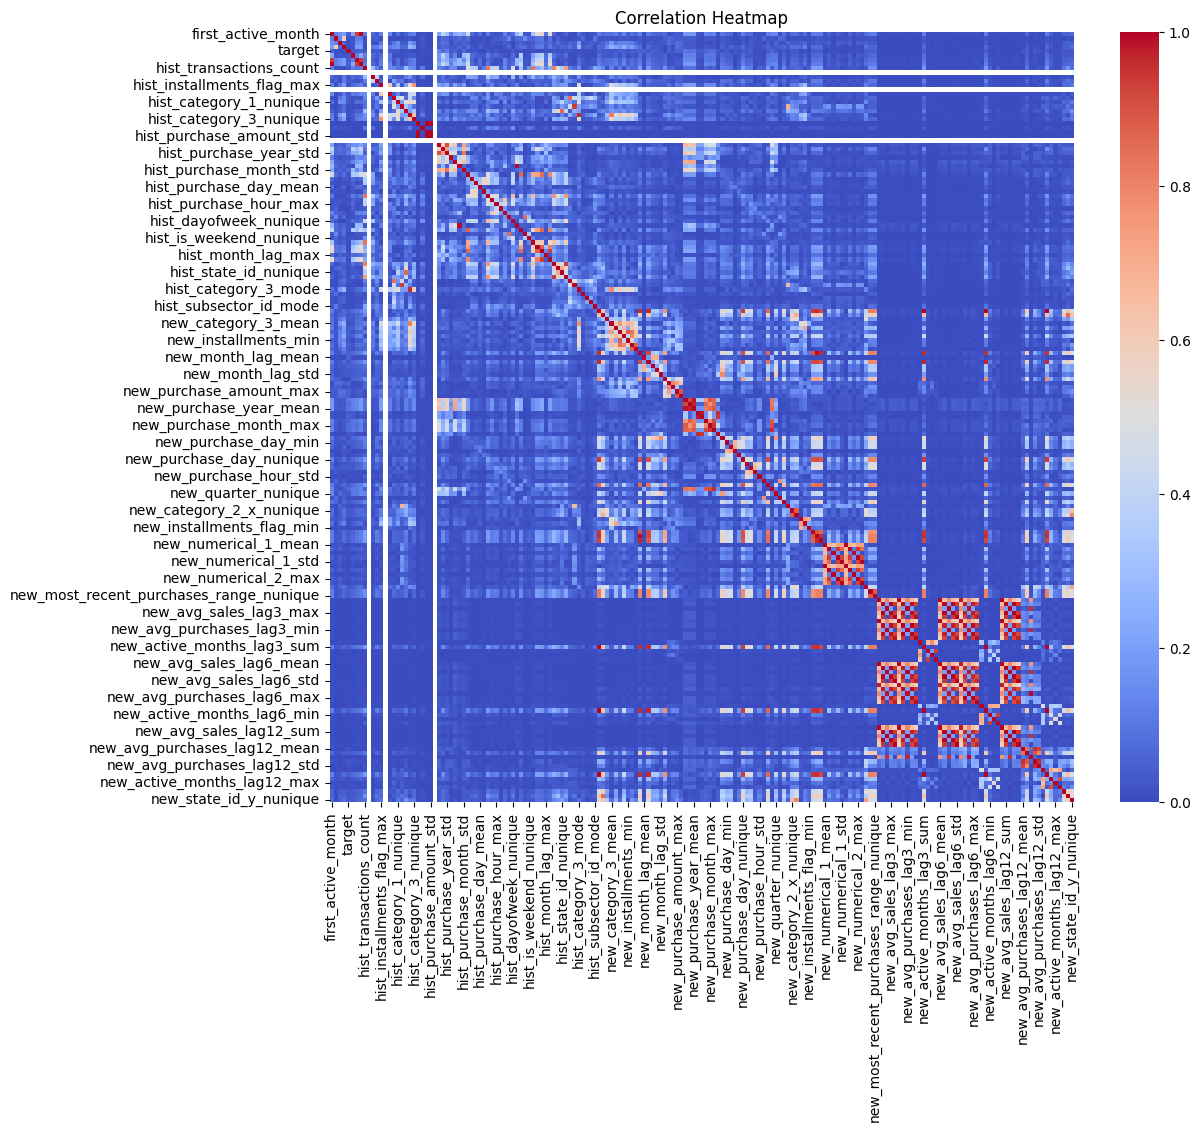

In [ ]:
corr_matrix = train_merge_data.corr().abs()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# 对数据标准化
scaler = StandardScaler()
train_merge_data_scaled = scaler.fit_transform(train_merge_data.drop(['target'], axis=1))
train_merge_data_scaled = pd.DataFrame(train_merge_data_scaled, columns=train_merge_data.drop(['target'], axis=1).columns)
train_merge_data_scaled['target'] = train_merge_data['target']
test_merge_data_scaled = scaler.transform(test_merge_data)


In [ ]:
train_merge_data_scaled.head()

,first_active_month,feature_1,feature_2,feature_3,month,year,time_diff,hist_transactions_count,hist_authorized_flag_max,hist_authorized_flag_min,...,new_avg_purchases_lag12_std,new_active_months_lag12_mean,new_active_months_lag12_sum,new_active_months_lag12_min,new_active_months_lag12_max,new_active_months_lag12_std,new_category_4_nunique,new_city_id_y_nunique,new_state_id_y_nunique,target
0,0.467491,1.597335,0.338839,0.876431,-0.412710,0.622562,-0.467481,0.000000,0.0,0.000000,...,-2.076730e-16,0.000000,3.001556e-16,9.274761e-16,-4.776907e-15,0.000000,-4.888832e-16,-2.226750e-16,0.000000,-0.820283
1,-0.050835,0.754276,-0.992082,-1.140992,-1.909398,0.622562,0.050828,0.000000,0.0,0.000000,...,-4.373408e-01,0.429252,1.089173e-01,5.938576e-01,9.463356e-02,-0.669761,-9.469876e-01,-9.369492e-01,-0.804579,0.392913
2,-0.569160,-0.931842,0.338839,-1.140992,0.185965,-0.646156,0.569137,-0.448803,0.0,-0.462394,...,-2.076730e-16,-3.125834,-1.200620e+00,-4.503876e-01,-5.283686e+00,0.000000,-9.469876e-01,-9.369492e-01,-0.804579,0.688056
3,0.778486,0.754276,1.669759,-1.140992,0.485303,0.622562,-0.778466,0.211892,0.0,2.339349,...,-4.592158e-01,0.429252,3.623762e-01,5.938576e-01,9.463356e-02,-0.669761,-9.469876e-01,6.588966e-02,0.753943,0.142495
4,0.985817,-1.774901,1.669759,-1.140992,1.083978,0.622562,-0.985789,1.300095,0.0,-0.462394,...,-2.076730e-16,0.000000,3.001556e-16,9.274761e-16,-4.776907e-15,0.000000,-4.888832e-16,-2.226750e-16,0.000000,-0.159749


In [ ]:
small_data = train_merge_data_scaled.sample(frac=0.1, random_state=42)

In [ ]:
small_data.shape

(20192, 181)

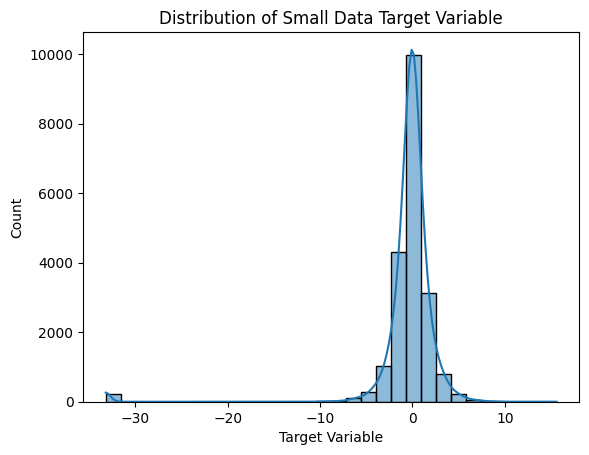

In [ ]:
# plt.figure(figsize=(12, 6))
sns.histplot(small_data['target'], bins=30, kde=True)
plt.title('Distribution of Small Data Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()

In [ ]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(small_data.drop(['target'], axis=1), small_data['target'], test_size=0.2, random_state=42)

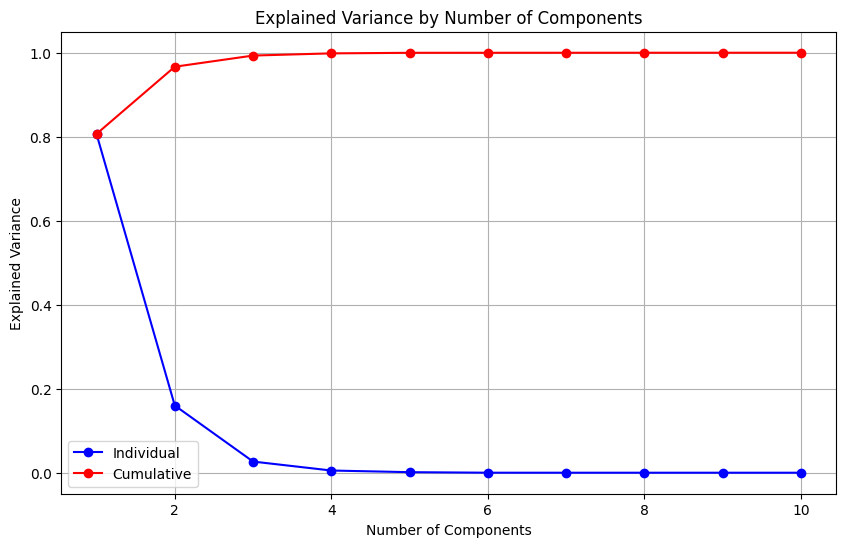

In [ ]:
# 使用pca降维 并可视化
PCA_feature = PCA(n_components=10)
PCA_feature.fit(train_merge_data.drop(['target'], axis=1))
explained_variance = PCA_feature.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.legend(['Individual', 'Cumulative'])
plt.grid(True)
plt.show()

In [ ]:
PCA_feature = PCA(n_components=4)
PCA_feature.fit(train_merge_data.drop(['target'], axis=1))
PCA_train = PCA_feature.transform(train_merge_data.drop(['target'], axis=1))
PCA_test = PCA_feature.transform(test_merge_data)

In [ ]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(PCA_train, train_merge_data['target'], test_size=0.2, random_state=42)

In [ ]:
# If I use mean as predictions
y_pred_test_mean = np.full(y_test.shape, y_train.mean())
test_rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_test_mean))
print("Test RMSE Mean:", test_rmse_mean)

Test RMSE Mean: 3.5254492436199536


In [ ]:
# 使用lasso linear regression预测
# 不用pca
# 使用cv = 5 进行交叉验证
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 1 , 1.5, 2, 3, 10]
lr_model = LassoCV(alphas=alphas, cv=5)
lr_model.fit(x_train, y_train)
best_alpha = lr_model.alpha_
print("Best alpha:", best_alpha)

Best alpha: 0.1


In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
y_pred_train_lasso = lasso.predict(x_train)
y_pred_test_lasso = lasso.predict(x_test)
train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_pred_train_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
print("Train RMSE Lasso:", train_rmse_lasso)
print("Test RMSE Lasso:", test_rmse_lasso)

Train RMSE Lasso: 3.774057788057044
Test RMSE Lasso: 3.48141472898809


In [ ]:
lasso = Lasso(alpha=50)
lasso.fit(x_train_pca, y_train_pca)
y_pred_train_lasso = lasso.predict(x_train_pca)
y_pred_test_lasso = lasso.predict(x_test_pca)
train_rmse_lasso = np.sqrt(mean_squared_error(y_train_pca, y_pred_train_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test_pca, y_pred_test_lasso))
print("Train RMSE Lasso:", train_rmse_lasso)
print("Test RMSE Lasso:", test_rmse_lasso)

Train RMSE Lasso: 3.844046711738875
Test RMSE Lasso: 3.8760993636505865


In [ ]:
# 使用svr进行预测
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(x_train, y_train)
y_pred_train_svr = svr.predict(x_train)
y_pred_test_svr = svr.predict(x_test)
train_rmse_svr = np.sqrt(mean_squared_error(y_train, y_pred_train_svr))
test_rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_test_svr))
print("Train RMSE SVR:", train_rmse_svr)
print("Test RMSE SVR:", test_rmse_svr)

Train RMSE SVR: 2.3135827250612735
Test RMSE SVR: 3.699641674712102


In [ ]:
# 使用random forest进行预测
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred_train_less = rf.predict(x_train)
y_pred_test_less = rf.predict(x_test)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_less))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_less))
print("Train RMSE RF:", train_rmse_rf)
print("Test RMSE RF:", test_rmse_rf)

Train RMSE RF: 1.492380091387956
Test RMSE RF: 3.5708170136208266


In [ ]:
# 使用xgboost进行预测
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
y_pred_train_xgb = xgb.predict(x_train)
y_pred_test_xgb = xgb.predict(x_test)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
print("Train RMSE XGB:", train_rmse_xgb)
print("Test RMSE XGB:", test_rmse_xgb)

Train RMSE XGB: 1.5912002890097372
Test RMSE XGB: 3.6914986302141837


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_merge_data_scaled.drop(['target'], axis=1), train_merge_data['target'], test_size=0.2, random_state=42)

In [ ]:
# 使用ann进行预测
input_layer = Dense(100, activation='relu', input_shape= X_train.shape[1:])

# Set different layer
hidden_layer_1= Dense(50, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1))
batch_normalization_layer1 = BatchNormalization()
droupout_layer_1 = Dropout(0.5)

# Set output layer
output_layer = Dense(units=1, activation='linear')

# assign layers
layers = [
    input_layer,
    hidden_layer_1,
    batch_normalization_layer1,
    droupout_layer_1,
    output_layer
]

# Create the model
model1 = Sequential(layers)
model1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                     │ (None, 100)                 │          18,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,401 (91.41 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 26.9493 - rmse: 3.2908 - val_loss: 15.1083 - val_rmse: 3.0378
Epoch 2/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 14.8355 - rmse: 3.0679 - val_loss: 15.0421 - val_rmse: 3.0226
Epoch 3/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 15.4380 - rmse: 3.1531 - val_loss: 14.7699 - val_rmse: 3.0185
Epoch 4/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 14.8608 - rmse: 3.0683 - val_loss: 14.5770 - val_rmse: 3.0380
Epoch 5/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 14.9577 - rmse: 3.0787 - val_loss: 15.0134 - val_rmse: 3.0819
Epoch 6/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 14.8661 - rmse: 3.0591 - val_loss: 14.5629 - val_rmse: 3.0268
Epoch 7/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 15.1092 - rmse: 3.1236 - val_loss: 14.4771 - val_rmse: 3.0212
Epoch 8/20
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 14.2588 - rmse: 3.0037 - val_loss: 14.3277 - val_rmse: 3.0583


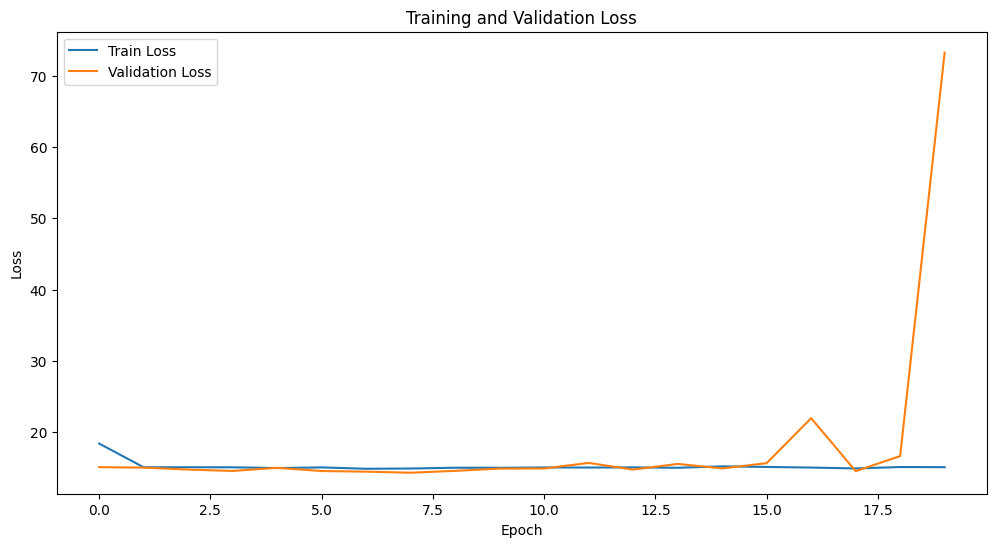

In [ ]:
# define metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[rmse])

# Train the model
history = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Visulize
plt.figure(figsize=(12, 6))
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()




In [ ]:
y_pred_ann = model1.predict(X_test)
y_pred_train_ann = model1.predict(X_train)
rmse_train_ann = np.sqrt(mean_squared_error(y_train, y_pred_train_ann))
rmse_test_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
print("Train RMSE ANN:", rmse_train_ann)
print("Test RMSE ANN:", rmse_test_ann)

1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
5048/5048 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Train RMSE ANN: 8.955240634486024
Test RMSE ANN: 21.898713112585504


In [ ]:
# 使用ann进行预测
input_layer = Dense(100, activation='relu', input_shape=X_train.shape[1:])

# Set different layer
hidden_layer_1= Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.05))
batch_normalization_layer1 = BatchNormalization()
hidden_layer_2= Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01))
droupout_layer_1 = Dropout(0.5)
hidden_layer_3= Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.05))
batch_normalization_layer2 = BatchNormalization()
hidden_layer_4= Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.01))
droupout_layer_2= Dropout(0.5)
hidden_layer_5= Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.05))
batch_normalization_layer3 = BatchNormalization()
hidden_layer_6= Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.01))

# Set output layer
output_layer = Dense(units=1, activation='linear')

# assign layers
layers = [
    input_layer,
    hidden_layer_1,
    batch_normalization_layer1,
    hidden_layer_2,
    droupout_layer_1,
    hidden_layer_3,
    batch_normalization_layer2,
    hidden_layer_4,
    droupout_layer_2,
    batch_normalization_layer3,
    hidden_layer_5,
    hidden_layer_6,
    output_layer
]

# Create the model
model2 = Sequential(layers)
model2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 100)                 │          18,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 25)                  │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 20)                  │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,896 (140.22 KB)

 Trainable params: 35,606 (139.09 KB)

 Non-trainable params: 290 (1.13 KB)

Epoch 1/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 15.9784 - rmse: 3.1471 - val_loss: 14.6174 - val_rmse: 3.0715
Epoch 2/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 14.7045 - rmse: 3.0990 - val_loss: 14.6856 - val_rmse: 3.0836
Epoch 3/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 14.8162 - rmse: 3.1278 - val_loss: 14.5686 - val_rmse: 3.0807
Epoch 4/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 14.8619 - rmse: 3.1177 - val_loss: 14.4522 - val_rmse: 3.0576
Epoch 5/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 15.3601 - rmse: 3.1823 - val_loss: 14.5489 - val_rmse: 3.0905
Epoch 6/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 14.7406 - rmse: 3.1240 - val_loss: 14.5622 - val_rmse: 3.1054
Epoch 7/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 14.3525 - rmse: 3.0948 - val_loss: 14.5502 - val_rmse: 3.0944
Epoch 8/10
4039/4039 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 14.3680 - rmse: 3.0751 - val_loss: 14.5569 - val_rmse: 3.1014


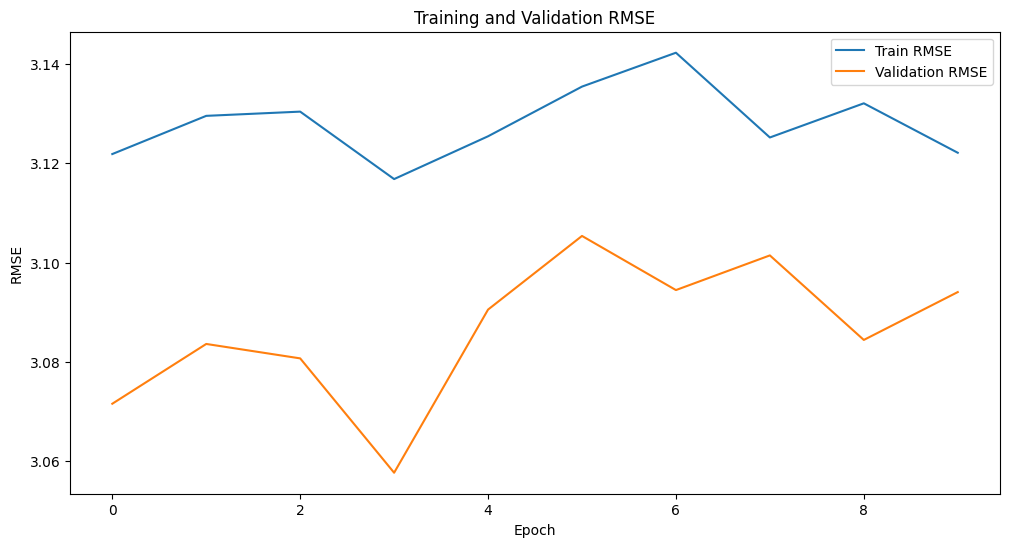

In [ ]:
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=[rmse])

# Train the model
history = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Visulize
plt.figure(figsize=(12, 6))
sns.lineplot(x=history.epoch, y=history.history['rmse'], label='Train RMSE')
sns.lineplot(x=history.epoch, y=history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()


In [ ]:
y_pred_ann = model2.predict(X_test)
y_pred_train_ann = model2.predict(X_train)
rmse_train_ann = np.sqrt(mean_squared_error(y_train, y_pred_train_ann))
rmse_test_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
print("Train RMSE ANN:", rmse_train_ann)
print("Test RMSE ANN:", rmse_test_ann)

1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
5048/5048 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Train RMSE ANN: 3.844337896154002
Test RMSE ANN: 3.8762923955830697


In [ ]:
# 如果使用去掉-30target的数据
train_merge_data_remove = train_merge_data[train_merge_data['target'] >= -30]

In [ ]:
x_train_remove, x_test_remove, y_train_remove, y_test_remove = train_test_split(train_merge_data_remove.drop(['target'], axis=1), train_merge_data_remove['target'], test_size=0.2, random_state=42)

In [ ]:
# 使用lasso linear regression预测
# 使用cv = 5 进行交叉验证
alphas = [0.0001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
lr_model = LassoCV(alphas=alphas, cv=5)
lr_model.fit(x_train_remove, y_train_remove)
best_alpha = lr_model.alpha_
print("Best alpha:", best_alpha)

Best alpha: 0.001


In [ ]:
lasso = Lasso(alpha=0.001)
lasso.fit(x_train_remove, y_train_remove)
y_pred_train_lasso = lasso.predict(x_train_remove)
y_pred_test_lasso = lasso.predict(x_test_remove)
train_rmse_lasso = np.sqrt(mean_squared_error(y_train_remove, y_pred_train_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test_remove, y_pred_test_lasso))
print("Train RMSE Lasso:", train_rmse_lasso)
print("Test RMSE Lasso:", test_rmse_lasso)

Train RMSE Lasso: 1.6549112954695666
Test RMSE Lasso: 1.7418557896815083


In [ ]:
# 使用Ensemble模型 随机森林， xbboost预测
# 分离数据集
data = train_merge_data_scaled.copy()

# 划分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 分割训练集，根据target的值选择模型
train_less = train_data[train_data['target'] < -30]
train_more = train_data[train_data['target'] >= -30]
test_less = test_data[test_data['target'] < -30]
test_more = test_data[test_data['target'] >= -30]

# 定义特征和标签
features = data.columns.drop('target')
x_train_less = train_less[features]
y_train_less = train_less['target']
x_train_more = train_more[features]
y_train_more = train_more['target']
x_test_less = test_less[features]
y_test_less = test_less['target']
x_test_more = test_more[features]
y_test_more = test_more['target']

In [ ]:
train_data.shape

(161533, 169)

In [ ]:
# apply target less than -30 subset data to ann
input_layer = Dense(300, activation='relu', input_shape=  x_train_less.shape[1:])

# Set hidden layer
hidden_layer_1= Dense(100, activation='relu')
hidden_layer_2= Dense(200, activation='relu')
hidden_layer_3= Dense(50, activation='relu')
hidden_layer_4= Dense(100, activation='relu')
hidden_layer_5= Dense(50, activation='relu')
hidden_layer_6= Dense(25, activation='relu')

# Set output layer
output_layer = Dense(units=1, activation='linear')

# assign layers
layers = [
    input_layer,
    hidden_layer_1,
    hidden_layer_2,
    hidden_layer_3,
    hidden_layer_4,
    hidden_layer_5,
    hidden_layer_6,
    output_layer
]

# Create the model
model = Sequential(layers)
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                     │ (None, 300)                 │          54,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,101 (492.58 KB)

 Trainable params: 126,101 (492.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 597.3339 - rmse: 22.4306 - val_loss: 46.5449 - val_rmse: 6.7445
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.2580 - rmse: 6.0875 - val_loss: 21.2877 - val_rmse: 4.5307
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.1882 - rmse: 4.0094 - val_loss: 17.8904 - val_rmse: 4.1416
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4890 - rmse: 3.2806 - val_loss: 12.8677 - val_rmse: 3.5066
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.1354 - rmse: 4.1625 - val_loss: 12.6929 - val_rmse: 3.4563
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2769 - rmse: 2.8209 - val_loss: 9.5992 - val_rmse: 3.0160
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3727 - rmse: 2.1717 - val_loss: 8.6423 - val_rmse: 2.8552
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3078 - rmse: 1.9537 - val_loss: 7.8315 - val_rmse: 2.7392
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

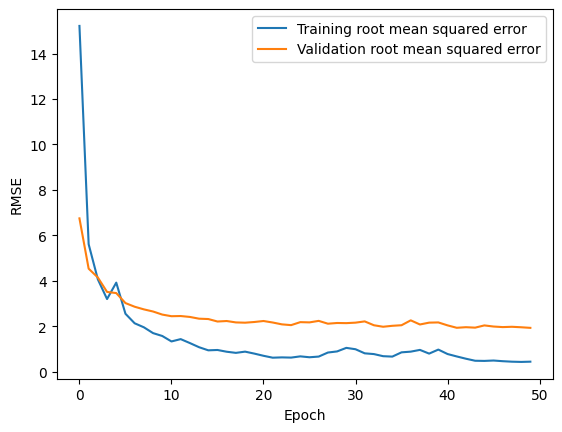

In [ ]:
model.compile(optimizer= Adam(learning_rate= 0.001), loss='mean_squared_error', metrics = [rmse])
history = model.fit(x_train_less, y_train_less, epochs=50, batch_size=32, validation_split=0.2)

plt.plot(history.history['rmse'], label='Training root mean squared error')
plt.plot(history.history['val_rmse'], label='Validation root mean squared error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
ann_pred_train_less = model.predict(x_train_less)
ann_pred_test_less = model.predict(x_test_less)
rmse_train_ann = np.sqrt(mean_squared_error(y_train_less, ann_pred_train_less))
rmse_test_ann = np.sqrt(mean_squared_error(y_test_less, ann_pred_test_less))
print("Train RMSE ANN:", rmse_train_ann)
print("Test RMSE ANN:", rmse_test_ann)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train RMSE ANN: 0.9661025341629415
Test RMSE ANN: 3.3727852197783936


In [ ]:
ann_pred_train_less.shape

(1757, 1)

In [ ]:
# # apply target more than -30 subset data to ann
input_layer = Dense(300, activation='relu', input_shape=  x_train_more.shape[1:])

# Set hidden layer
hidden_layer_1= Dense(100, activation='relu')
hidden_layer_2= Dense(200, activation='relu')
hidden_layer_3= Dense(50, activation='relu')
hidden_layer_4= Dense(100, activation='relu')
hidden_layer_5= Dense(50, activation='relu')
hidden_layer_6= Dense(25, activation='relu')

# Set output layer
output_layer = Dense(units=1, activation='linear')

# assign layers
layers = [
    input_layer,
    hidden_layer_1,
    hidden_layer_2,
    hidden_layer_3,
    hidden_layer_4,
    hidden_layer_5,
    hidden_layer_6,
    output_layer
]

# Create the model
model = Sequential(layers)
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                     │ (None, 300)                 │          54,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,101 (492.58 KB)

 Trainable params: 126,101 (492.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 668.0325 - rmse: 24.3575 - val_loss: 109.1252 - val_rmse: 10.3537
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 62.6898 - rmse: 7.7708 - val_loss: 29.6012 - val_rmse: 5.3733
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 26.1017 - rmse: 5.0501 - val_loss: 20.0358 - val_rmse: 4.4091
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.5875 - rmse: 3.9552 - val_loss: 16.4261 - val_rmse: 3.9760
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.3286 - rmse: 3.2270 - val_loss: 12.7525 - val_rmse: 3.4854
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4936 - rmse: 2.9538 - val_loss: 11.2759 - val_rmse: 3.2722
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.3165 - rmse: 2.8305 - val_loss: 12.7975 - val_rmse: 3.4928
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8580 - rmse: 2.7377 - val_loss: 10.3421 - val_rmse: 3.1396
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━

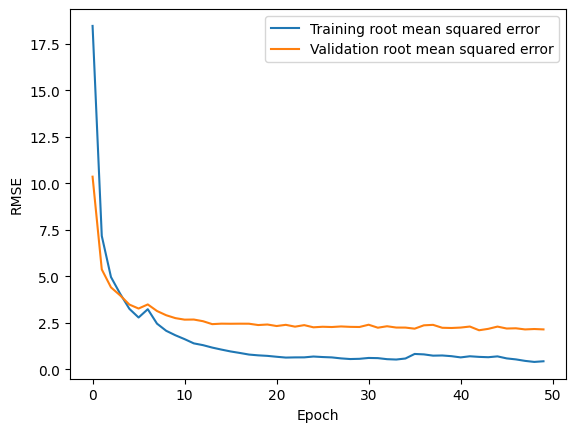

In [ ]:
model.compile(optimizer= Adam(learning_rate= 0.001), loss='mean_squared_error', metrics = [rmse])
history = model.fit(x_train_less, y_train_less, epochs=50, batch_size=32, validation_split=0.2)

plt.plot(history.history['rmse'], label='Training root mean squared error')
plt.plot(history.history['val_rmse'], label='Validation root mean squared error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
ann_pred_train_more = model.predict(x_train_more)
ann_pred_test_more = model.predict(x_test_more)
rmse_train_ann = np.sqrt(mean_squared_error(y_train_more, ann_pred_train_more))
rmse_test_ann = np.sqrt(mean_squared_error(y_test_more, ann_pred_test_more))
print("Train RMSE ANN:", rmse_train_ann)
print("Test RMSE ANN:", rmse_test_ann)

4993/4993 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Train RMSE ANN: 34.32215509597323
Test RMSE ANN: 53.61729451890614


In [ ]:
# apply the target more than -30 subset data to rf model
# evaluate the model
xgb1 = XGBRegressor(
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.01,
    max_depth=3,
    min_child_weight=1,
    reg_alpha=0.01,
    random_state=42
)
xgb1.fit(x_train_more, y_train_more)
xgb_pred_train_more = xgb1.predict(x_train_more)
xgb_pred_test_more = xgb1.predict(x_test_more)
xgb_rmse_train_more = np.sqrt(mean_squared_error(y_train_more, xgb_pred_train_more))
xgb_rmse_test_more = np.sqrt(mean_squared_error(y_test_more, xgb_pred_test_more))
print("Train RMSE RF:", xgb_rmse_train_more)
print("Test RMSE RF:", xgb_rmse_test_more)

Train RMSE RF: 1.5956543593757329
Test RMSE RF: 1.5903282975994621


In [ ]:
xgb1.fit(x_train_less, y_train_less)
xgb_pred_train_less = xgb1.predict(x_train_less)
xgb_pred_test_less = xgb1.predict(x_test_less)
xgb_rmse_train_less = np.sqrt(mean_squared_error(y_train_less, xgb_pred_train_less))
xgb_rmse_test_less = np.sqrt(mean_squared_error(y_test_less, xgb_pred_test_less))
print("Train RMSE RF:", xgb_rmse_train_less)
print("Test RMSE RF:", xgb_rmse_test_less)

Train RMSE RF: 7.070800762676298e-07
Test RMSE RF: 7.070800762676298e-07


In [ ]:
xgb_pred_train_more=xgb_pred_train_more.reshape(-1, 1)
xgb_pred_test_more=xgb_pred_test_more.reshape(-1, 1)

In [ ]:
xgb_pred_train_more.shape

(159776, 1)

In [ ]:
#把more和less训练结果拼接
X_new_train = np.concatenate([ann_pred_train_less, xgb_pred_train_more]).reshape(-1, 1)
y_new_train = np.concatenate([y_train_less, y_train_more])
stacked_train = pd.DataFrame({
    'X_train': X_new_train.flatten(),
    'target_train': y_new_train
})
X_new_test = np.concatenate([ann_pred_test_less, xgb_pred_test_more]).reshape(-1, 1)
y_new_test = np.concatenate([y_test_less, y_test_more])
stacked_test = pd.DataFrame({
    'X_test': X_new_test.flatten(),
    'target_test': y_new_test
})


In [ ]:
meta_model = LinearRegression()
meta_model.fit(stacked_train['X_train'].values.reshape(-1, 1), stacked_train['target_train'])
prediction_train = meta_model.predict(stacked_train['X_train'].values.reshape(-1, 1))
prediction_test = meta_model.predict(stacked_test['X_test'].values.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(stacked_test['target_test'], prediction_test))
print("Test RMSE:", rmse)

Test RMSE: 1.5826143323905286


In [ ]:
# 使用random forest进行预测
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
y_pred_rf = rf.predict(x_test)
print("Mean RMSE:", rmse_scores.mean())
print("RMSE scores:", rmse_scores)

Mean RMSE: 3.8918116393793154
RMSE scores: [3.78877953 4.02221694 3.81592134 3.64523184 4.18690854]


In [ ]:
# find the best parameter in rf
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [3,4,5,6,7],
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)


Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# prediction with rf
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42)
scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())

RMSE scores: [3.6200292  3.85549735 3.75031741 3.43437286 4.11659023]
Mean RMSE: 3.7553614093441867


In [ ]:
y_pred_train_rf = rf.fit(x_train, y_train).predict(x_train)
y_pred_test_rf = rf.predict(x_test)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
print("Train RMSE RF:", train_rmse_rf)
print("Test RMSE RF:", test_rmse_rf)

Train RMSE RF: 3.479408217050193
Test RMSE RF: 3.457284278066315


In [ ]:
# find the best parameter in XGB
xgb = XGBRegressor(random_state=42)
param_grid = {
    'learning_rate': [0.1,0.01,0.001],
    'gamma': [0.2],
    'subsample': [0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [200],
    'max_depth': [5],
    'min_child_weight': [3],
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


In [ ]:
# prediction with xgboost
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    min_child_weight=3,
    gamma=0.2,
    subsample=0.9,
    colsample_bytree=0.5,
    learning_rate=0.01,
    random_state=42
)
scores = cross_val_score(xgb, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())

RMSE scores: [3.56694789 3.86843244 3.72715144 3.43700044 4.08206023]
Mean RMSE: 3.7363184894472057


In [ ]:
y_pred_train_xgb = xgb.fit(x_train, y_train).predict(x_train)
y_pred_test_xgb = xgb.predict(x_test)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
print("Train RMSE XGB:", train_rmse_xgb)
print("Test RMSE XGB:", test_rmse_xgb)

Train RMSE XGB: 3.3717623586790215
Test RMSE XGB: 3.452200258622068


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_merge_data_scaled.drop(['target'], axis=1), train_merge_data['target'], test_size=0.2, random_state=42)
xgb.fit(X_train, y_train)
y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
print("Train RMSE XGB:", train_rmse_xgb)
print("Test RMSE XGB:", test_rmse_xgb)

Train RMSE XGB: 3.6439076988102928
Test RMSE XGB: 3.733956821024011


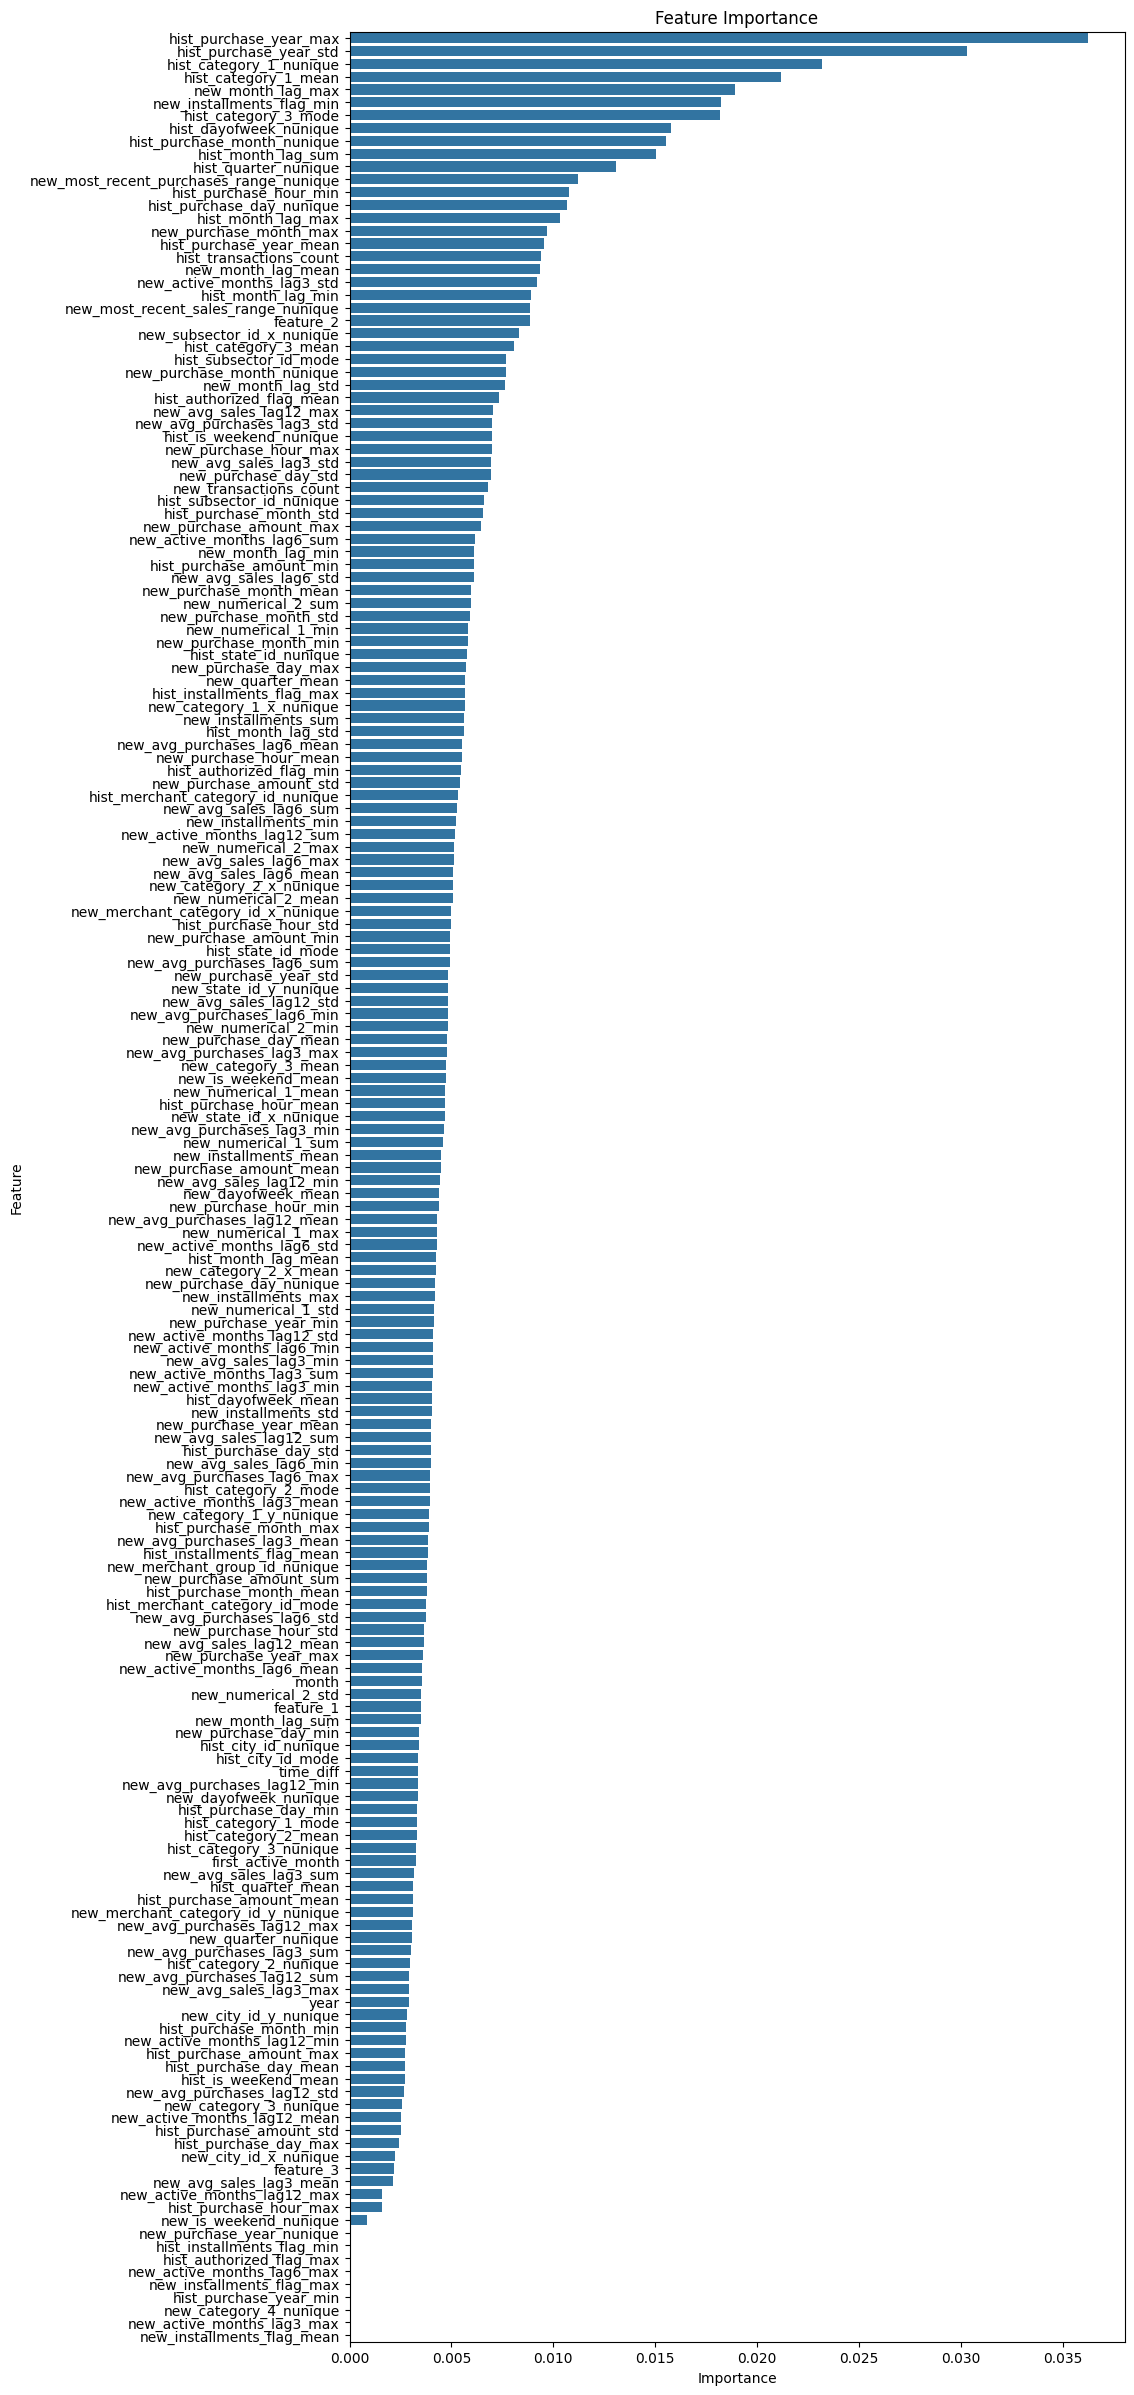

In [ ]:
# the importance rank of features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 30))
sns.barplot(x=feature_importance['importance'], y=feature_importance['feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
train_merge_data.head()

,first_active_month,feature_1,feature_2,feature_3,target,month,year,time_diff,hist_transactions_count,hist_authorized_flag_max,...,new_avg_purchases_lag12_max,new_avg_purchases_lag12_std,new_active_months_lag12_mean,new_active_months_lag12_sum,new_active_months_lag12_min,new_active_months_lag12_max,new_active_months_lag12_std,new_category_4_nunique,new_city_id_y_nunique,new_state_id_y_nunique
0,66,5,2,1,-0.820283,6,6,-0.467481,66.095824,1.0,...,1.294298,0.674761,11.758514,66.843313,10.862609,11.964809,0.52298,1.43011,1.934297,1.516245
1,61,4,1,0,0.392913,1,6,0.050828,66.095824,1.0,...,0.846137,0.207155,12.000000,72.000000,12.000000,12.000000,0.00000,1.00000,1.000000,1.000000
2,56,2,2,0,0.688056,8,5,0.569137,43.000000,1.0,...,0.741878,0.674761,10.000000,10.000000,10.000000,10.000000,0.52298,1.00000,1.000000,1.000000
3,69,4,3,0,0.142495,9,6,-0.778466,77.000000,1.0,...,0.897729,0.183766,12.000000,84.000000,12.000000,12.000000,0.00000,1.00000,2.000000,2.000000
4,71,1,3,0,-0.159749,11,6,-0.985789,133.000000,1.0,...,1.294298,0.674761,11.758514,66.843313,10.862609,11.964809,0.52298,1.43011,1.934297,1.516245


In [ ]:
 # y_pred_test = model.predict(test_merge_data_scaled)
# output = pd.DataFrame({
#     'card_id': cardid_test,
#     'target': y_pred_test.flatten()
# })
# output.to_csv('submission.csv', index=False)

3864/3864 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
